In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm
plt.rcParams['figure.figsize'] = [8, 8]

#Function definition and plot

Since χ is in the [0,1] interval, computing the values of f on the extremes of the interval, we get f ∈ [1/sqrt(2), 1], and we must consider that f goes to infinity for χ going to 1, hence I do not set 1 as right boundary of the interval but I set a 0.9999 (a value going to 1)


In [2]:
def pdf(f):
  return 2*(2*f**2 - 1) / np.sqrt(1-f**2)

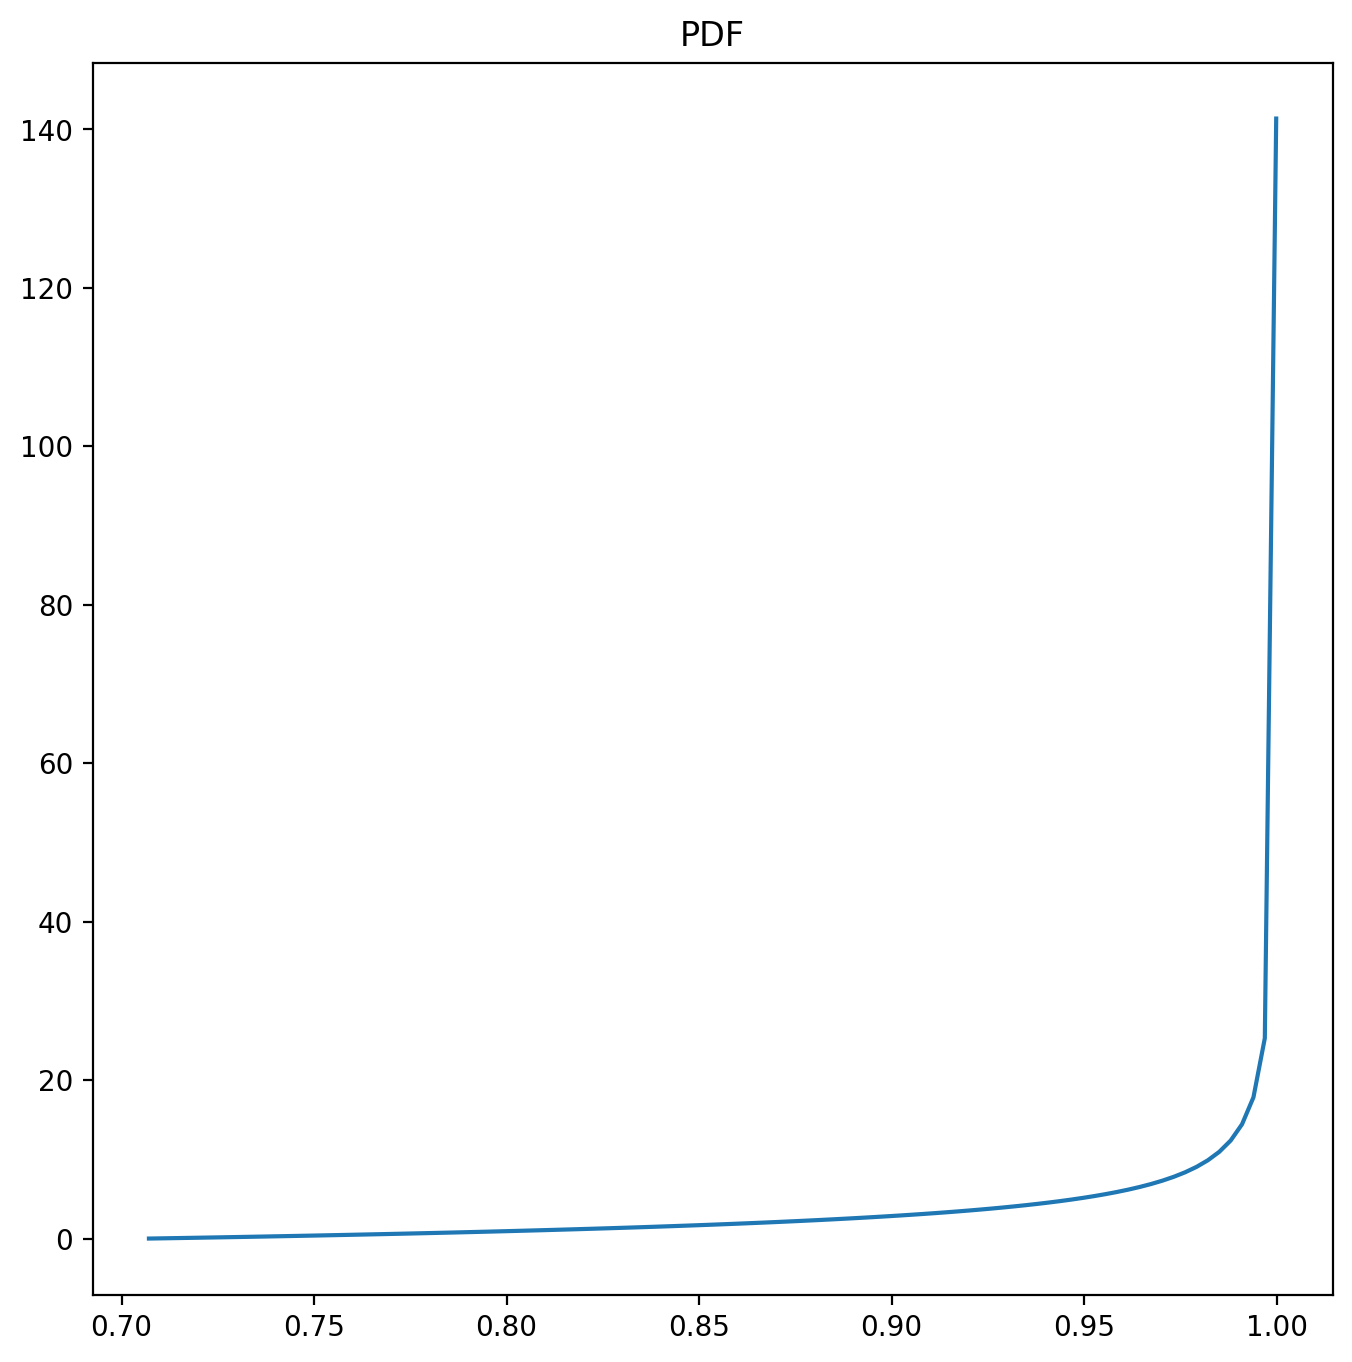

In [3]:
x_space = np.linspace(1/np.sqrt(2),.9999,100)
plt.title('PDF')
plt.plot(x_space,pdf(x_space))

#Rejection Sampling

In [4]:
def rejection_sampling(pdf, n_points, ymax, nbins, show=True):
  x = np.random.uniform(1/np.sqrt(2), 1 - 1e-5, n_points)
  y = np.random.uniform(0, ymax, n_points)

  xg = np.linspace(1/np.sqrt(2), 1 - 1e-5, 100)
  pdf_y_vals = pdf(xg)

  goodpoints = x[y<pdf(x)]

  if show:
    plt.plot(xg, pdf_y_vals)

    plt.scatter(x[y<pdf(x)],y[y<pdf(x)],c='yellow')
    plt.scatter(x[y>pdf(x)],y[y>pdf(x)],c='red')

    plt.ylim(bottom=0,top=ymax)
    plt.show()

    plt.plot(xg, pdf_y_vals, label="theoretical PDF", color="r")
    plt.hist(goodpoints, bins=nbins, density=True, histtype='step', color='green')

    plt.xlabel("x")
    plt.ylabel("PDF")
    plt.ylim(bottom=0,top=ymax)
    plt.title("Rejection Sampling")

    plt.show()

  return goodpoints

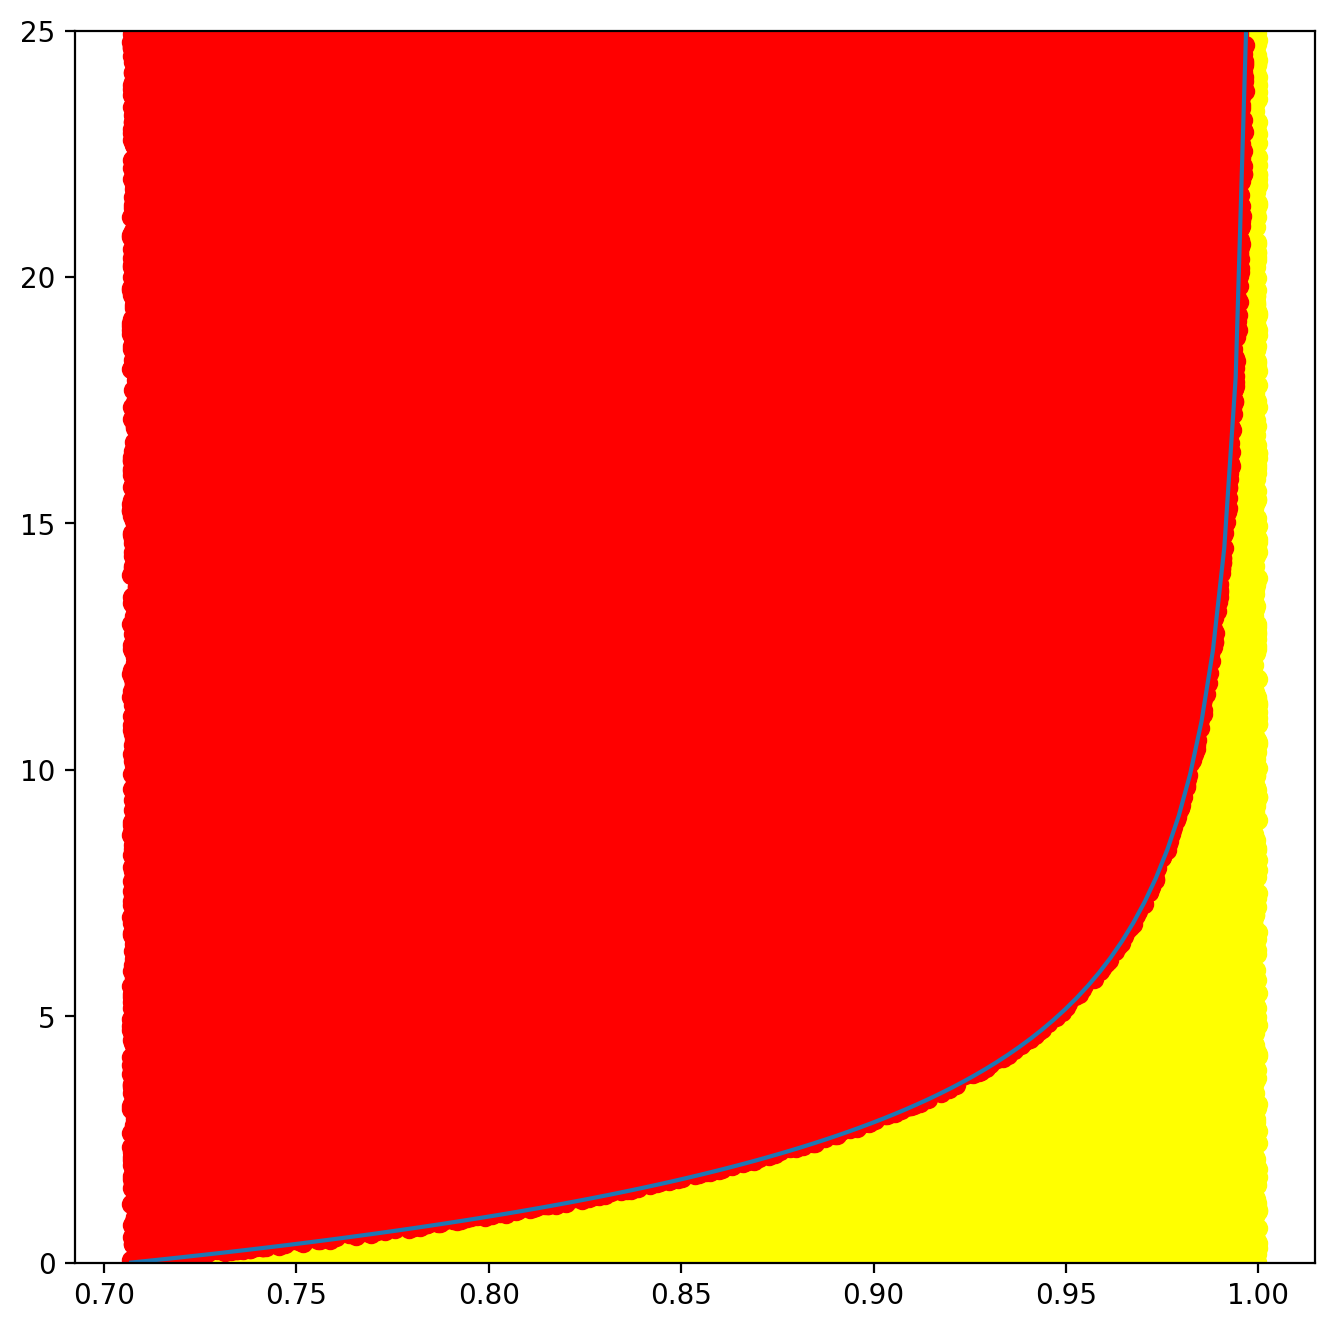

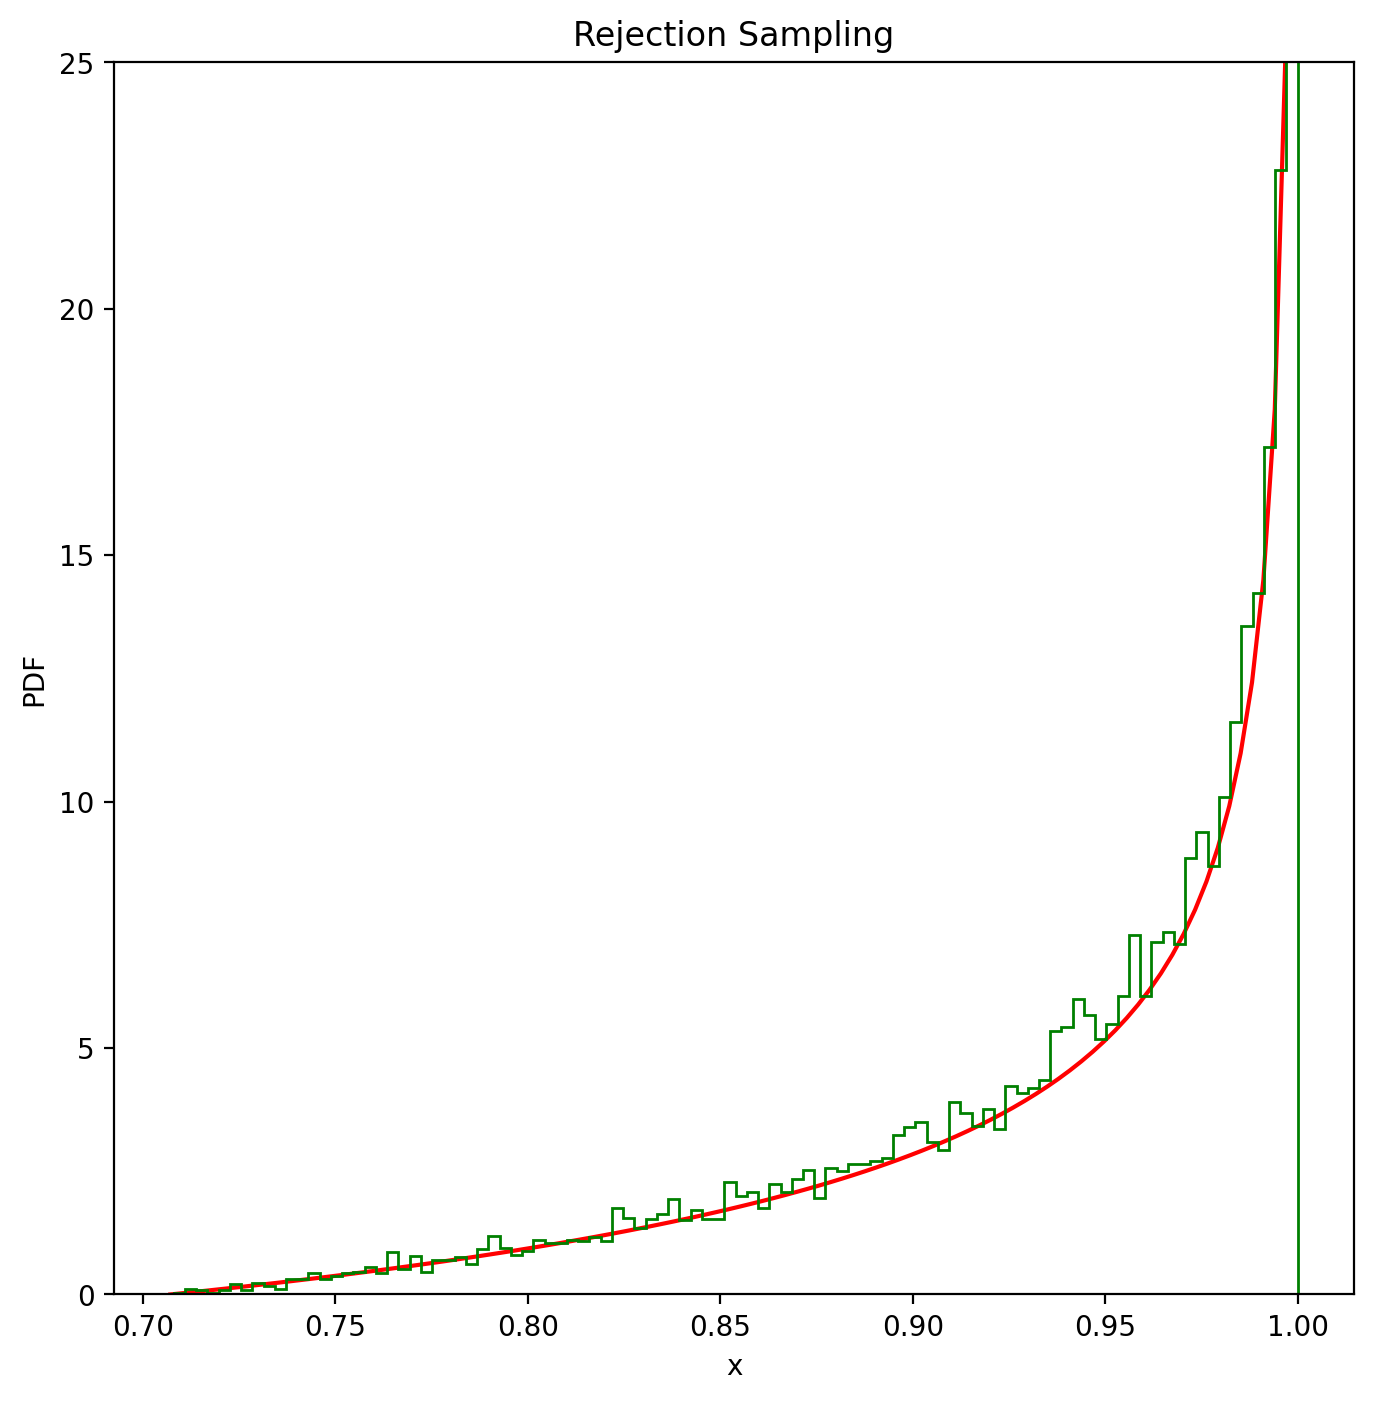

array([0.99378864, 0.93147728, 0.89477868, ..., 0.99911994, 0.88709987,
       0.84429891])

In [5]:
rejection_sampling(pdf, 100000, 25, 100)

#Inverse Transform Sampling

I firstly compute the cdf of f numerically

In [6]:
from scipy import integrate

n_points = 1000
f_values = np.linspace(1/np.sqrt(2), 1, n_points)
cdf_values = np.zeros_like(f_values)
cumulative_integral = 0
for i in range(len(f_values)):
    integral, _ =  integrate.quad(pdf, 1/np.sqrt(2), f_values[i])
    cdf_values[i] = integral

Then I plot my results

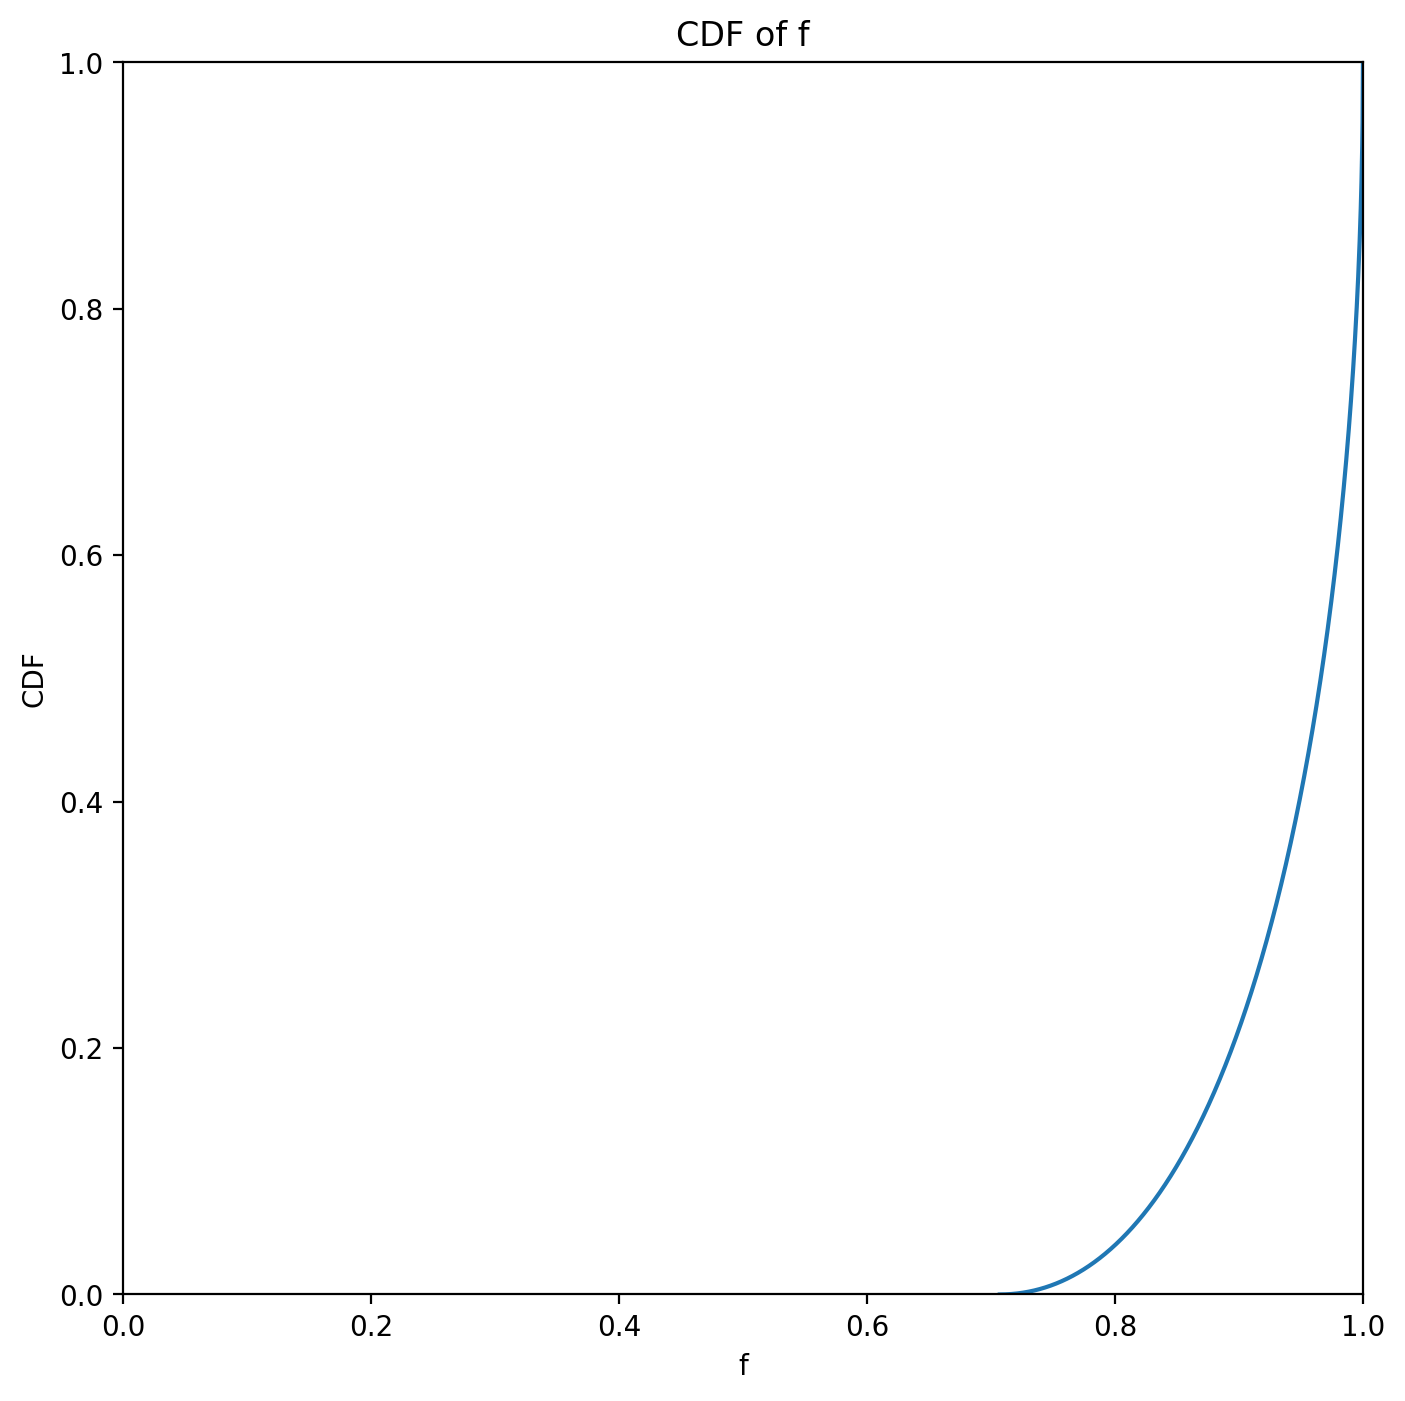

In [7]:
plt.plot(f_values, cdf_values)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("f")
plt.ylabel("CDF")
plt.title("CDF of f")

plt.show()

I now invert the cdf

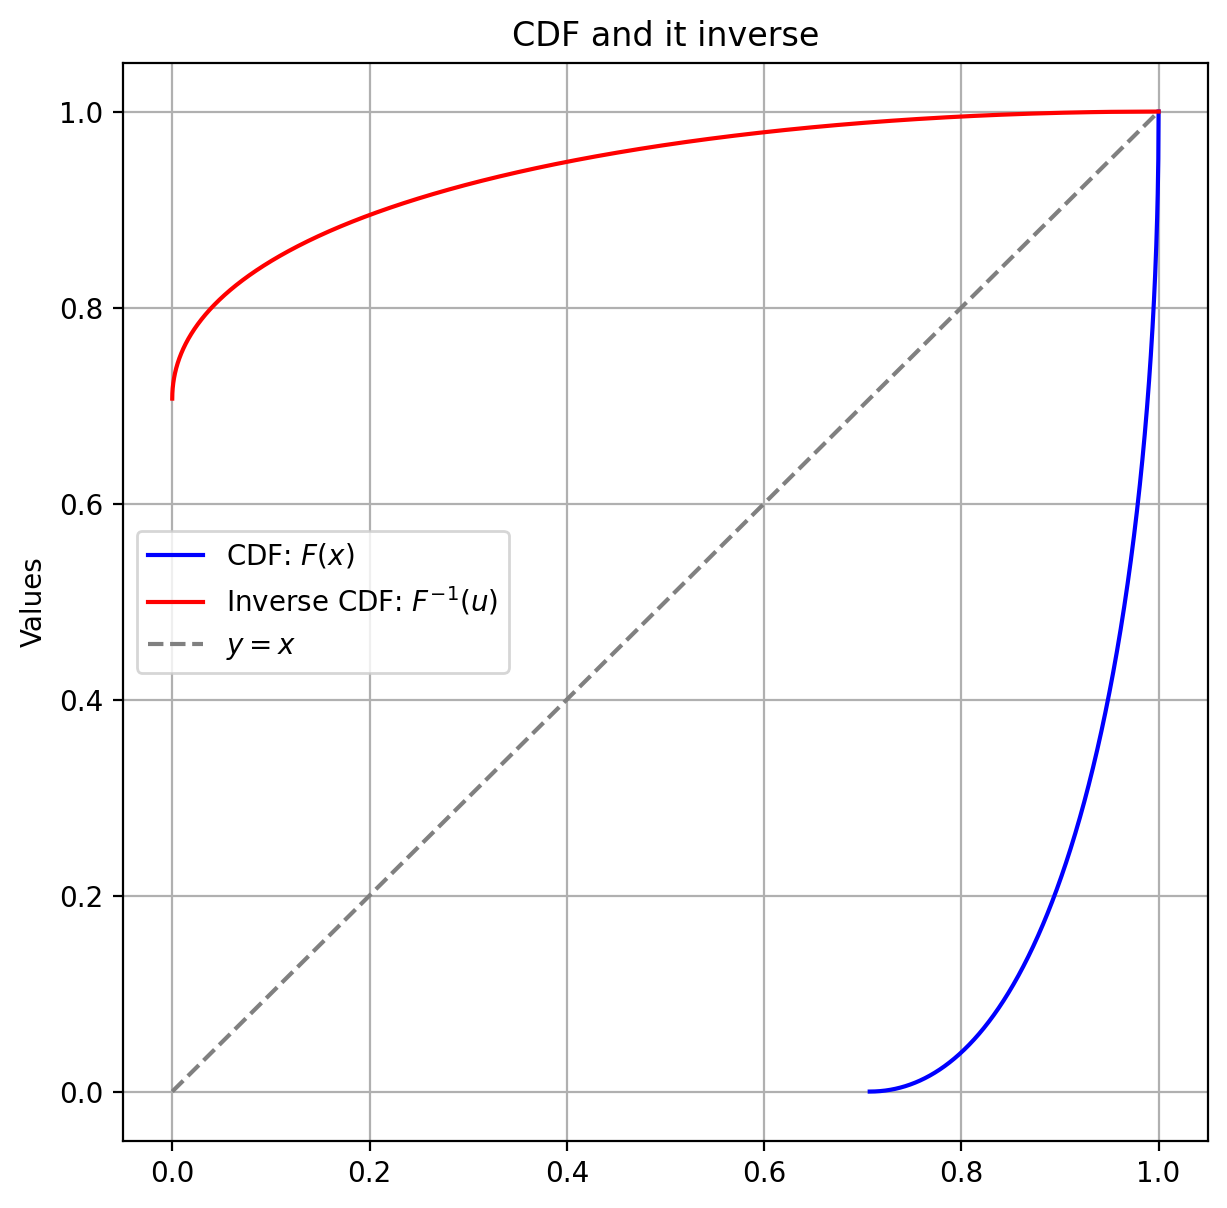

In [8]:
domain = np.linspace(1/np.sqrt(2), 1 - 1e-5, n_points)

inverse_cdf = interp1d(cdf_values, domain, fill_value="extrapolate")

plt.figure(figsize=(7, 7))
plt.plot(domain, cdf_values, label='CDF: $F(x)$', color='b')
plt.plot(cdf_values, domain, label='Inverse CDF: $F^{-1}(u)$', color='r')
plt.plot([0, 1], [0, 1], '--', color='gray', label='$y = x$')

plt.ylabel('Values')
plt.title('CDF and it inverse')
plt.legend()
plt.grid()

plt.show()

Now I sample the points

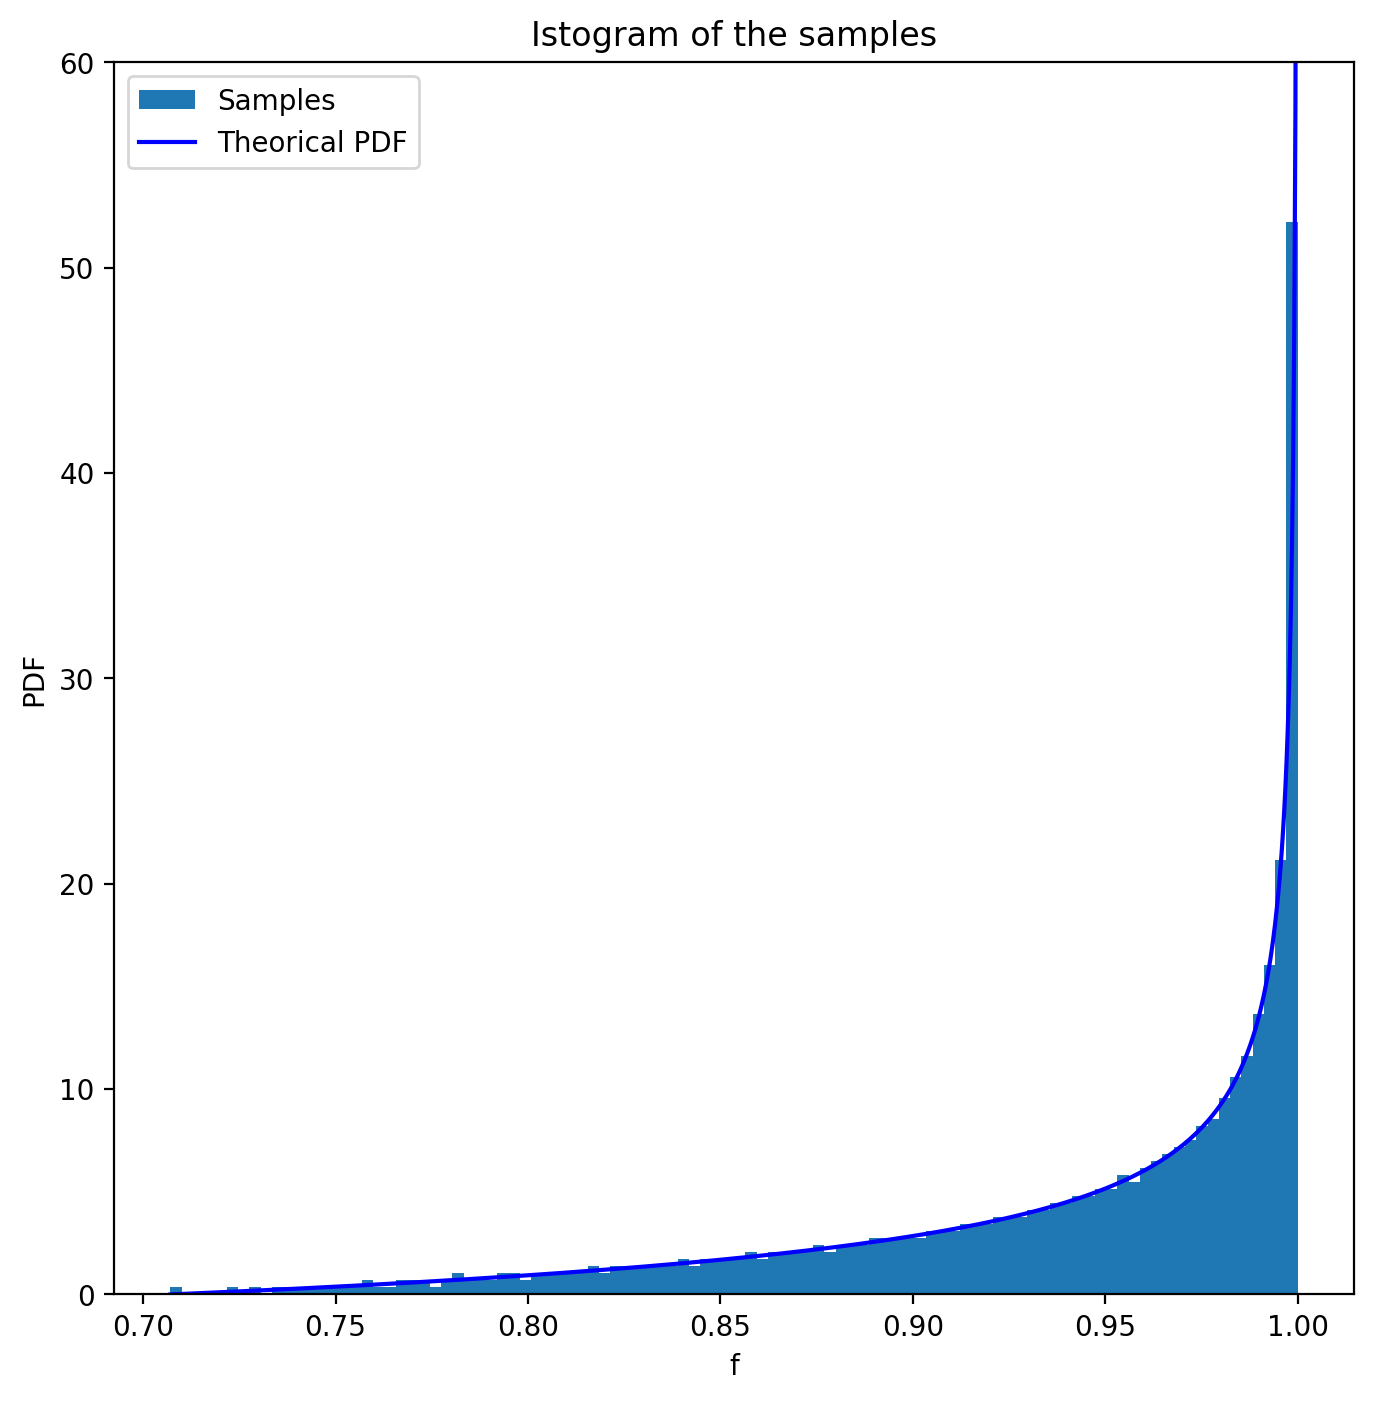

In [9]:
eps = np.linspace(0, 1, n_points)

samples = inverse_cdf(eps)

plt.hist(samples, bins=100, density=True, label='Samples')
plt.plot(domain, pdf(domain), label='Theorical PDF', color='b')

plt.xlabel('f')
plt.ylabel('PDF')
plt.title('Istogram of the samples')
plt.legend()
plt.ylim(bottom=0, top=60)

plt.show()

#PDF of $M_{irr}

In [10]:
def integrand(f, Mirr, mu, sigma):
  return (np.sqrt(2 / np.pi) / sigma) * np.exp(-((Mirr / f - mu)**2) / (2 * sigma**2)) * (2 * f**2 - 1) / (f * np.sqrt(1 - f**2))

In [11]:
def pdf_Mirr(Mirr, mu, sigma):
    result, _ = integrate.quad(integrand, 1/np.sqrt(2), 1, args=(Mirr, mu, sigma), limit=100)
    return result

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3871200694.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(Mirr_values, pdf_Mirr_values, label=f'$\mu={mu}, \sigma={sigma}$')
/tmp/ipython-input-3871200694.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(Mirr_values, pdf_Mirr_values, label=f'$\mu={mu}, \sigma={sigma}$')
/tmp/ipython-input-3668647256.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integrand, 1/np.sqrt(2), 1, args=(Mirr, mu, sigma), limit=100)


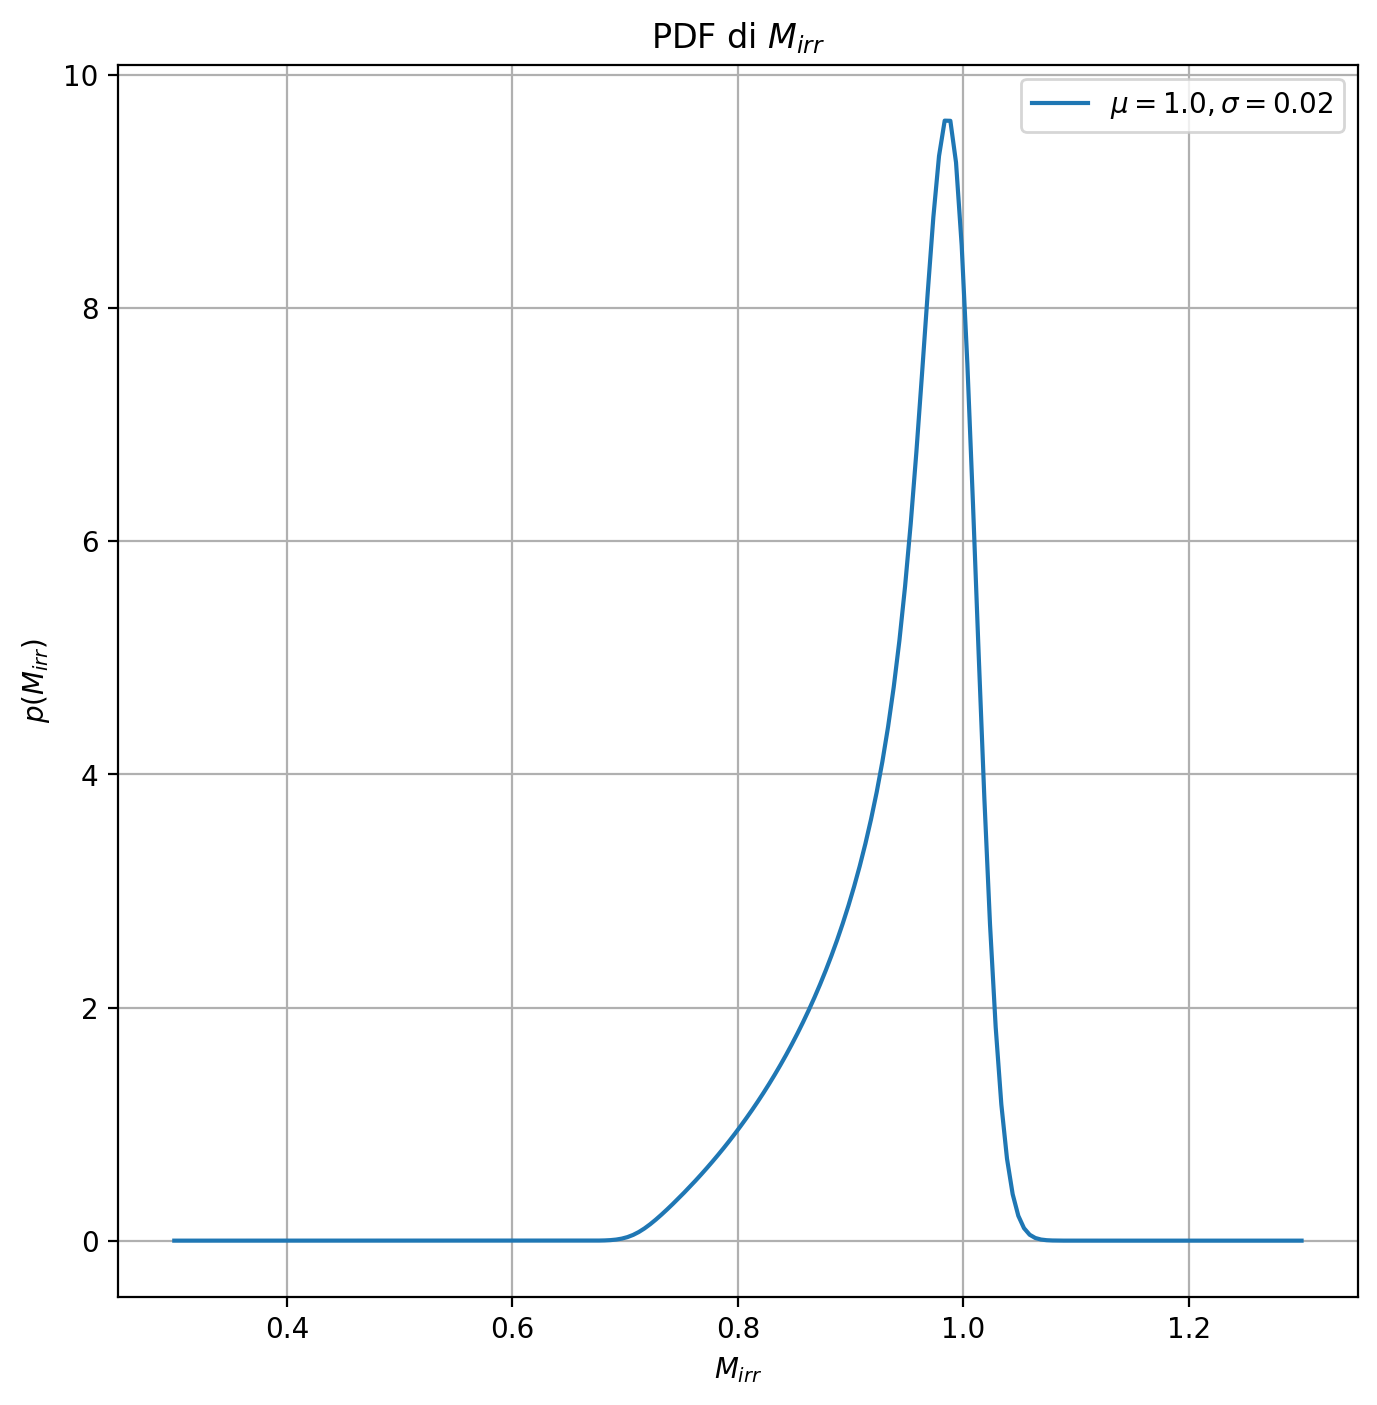

In [12]:
mu = 1.
sigma = .02
Mirr_values = np.linspace(0.3, 1.3, 200)
pdf_Mirr_values = [pdf_Mirr(m, mu, sigma) for m in Mirr_values]

plt.plot(Mirr_values, pdf_Mirr_values, label=f'$\mu={mu}, \sigma={sigma}$')
plt.xlabel('$M_{irr}$')
plt.ylabel('$p(M_{irr})$')
plt.title('PDF di $M_{irr}$')
plt.legend()
plt.grid(True)
plt.show()

#Sampling of the PDF of $M_{irr}$

I try to run rejection sampling using a gaussian bounding box

In [13]:
def rejection_sampling_Mirr(n_points, mu, sigma, ymax):
  goodpoints = []

  i = 0
  while i <= n_points:
    x = np.random.uniform(.65, 1.1)
    y = np.random.uniform(0, ymax)

    if y < pdf_Mirr(x, mu, sigma):
      goodpoints.append(x)

    i += 1
  return np.array(goodpoints)

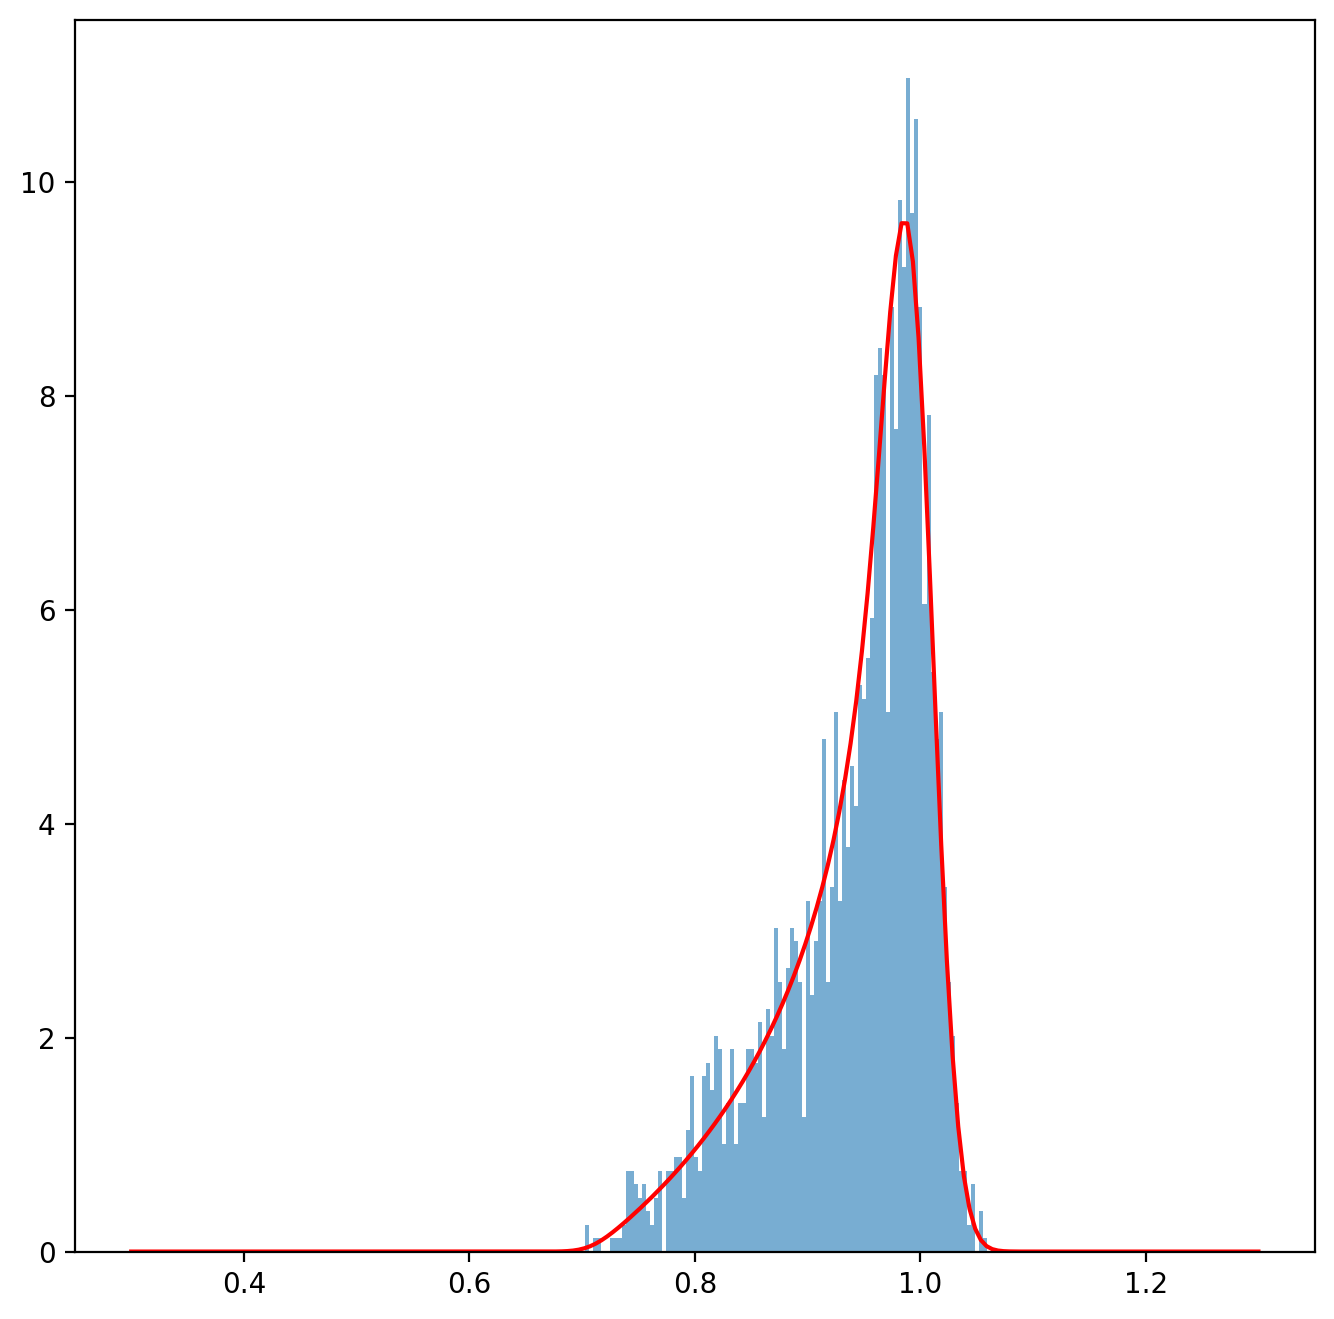

In [14]:
samples = rejection_sampling_Mirr(10000, 1, .02, max(pdf_Mirr_values))

plt.hist(samples, bins=100, density=True, alpha=.6, label='Samples')
plt.plot(Mirr_values, pdf_Mirr_values, label=f'Theorical PDF', color='r')

Then, being $M_{irr}$ a function of random variables with known distribution, I can sample the random varabiles used to compute it and use them to sample $M_{irr}$. \
That is, I can sample M and χ and use them to compute $M_{irr}$

In [15]:
def sampling(n_points, mu, sigma):
  M = np.random.normal(mu, sigma, n_points)
  chi = np.random. uniform(0, 1, n_points)

  M_irr = M*np.sqrt((1 + np.sqrt(1-chi**2))/2)

  return M_irr

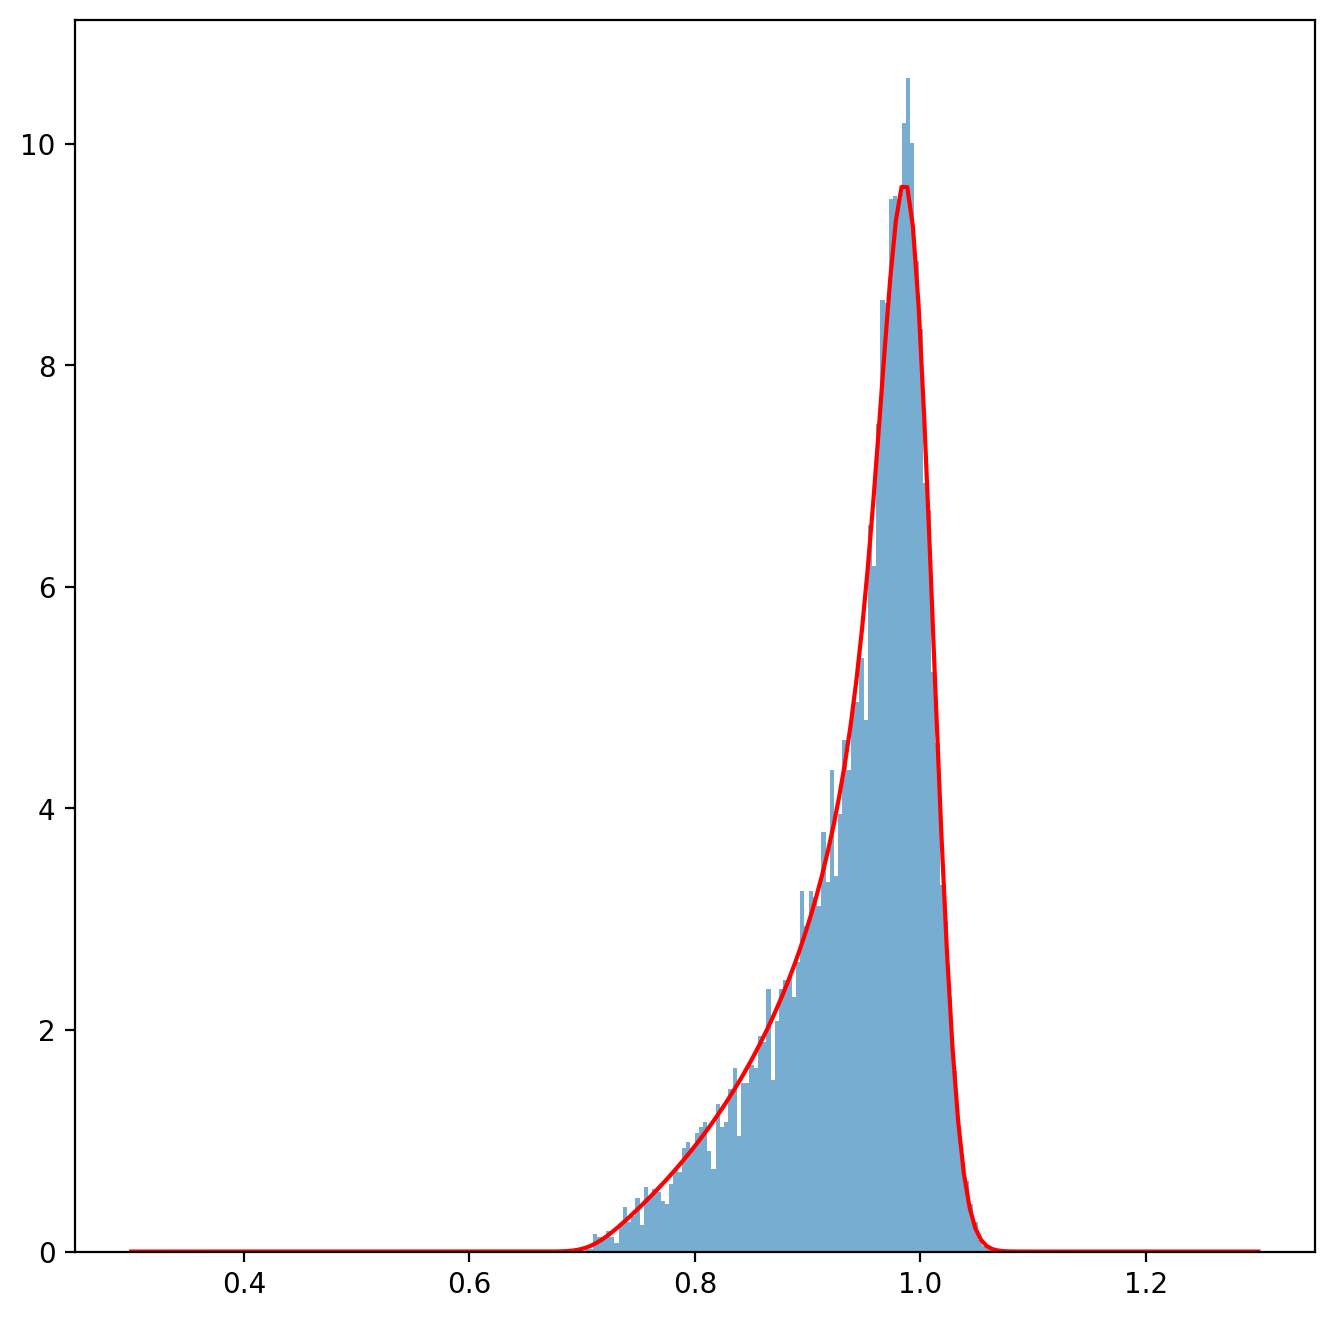

In [16]:
mirr_samples = sampling(10000, 1, .02)
plt.hist(mirr_samples, bins=100, density=True, alpha=.6, label='Samples')
plt.plot(Mirr_values, pdf_Mirr_values, label=f'Theorical PDF', color='r')

The same approach could be used considering M and f as sampled random variables, sampling f through one of the methods analyzed before